## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
#!pip install spacy
#!python -m spacy download en_core_web_sm
#!pip install textblob

In [2]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression


# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# figures
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import scattertext as st

In [3]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv").dropna()
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets

/var/folders/q8/ns_bcjlj3d1dv0ch0dh5n59r0000gn/T/ipykernel_24456/922644634.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv").dropna()


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.140000e+18,SpeakerPelosi,2019-06-14T16:45:25-04:00,.@JanSchakowsky is fighting alongside @HouseDe...,Nancy Pelosi,Rep,2-Jun-87,3/26/40,F,CA,12,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
1,1.110000e+18,GOPLeader,2019-04-04T16:01:15-04:00,RT @RepMichaelWaltz Today I asked the House to...,Kevin McCarthy,Rep,3-Jan-07,1/26/65,M,CA,23,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"
2,1.190000e+18,RepChuck,2019-10-31T11:52:00-04:00,"No matter how deep they dig, or how many secon...",Chuck Fleischmann,Rep,3-Jan-11,10/11/62,M,TN,3,Republican,"1,522,925","870,695","960,709","1,462,330"
3,1.250000e+18,McConnellPress,2020-04-10T14:50:04-04:00,"Talking directly with Simpson County families,...",Mitch McConnell,Sen,3-Jan-15,2/20/42,M,KY,Senate,Republican,"1,202,971","628,854","679,370","1,087,190"
4,1.200000e+18,RepSwalwell,2019-12-09T17:17:17-05:00,RT @StandUpAmerica .@RepSwalwell outlines Trum...,Eric Swalwell,Rep,3-Jan-13,11/16/80,M,CA,15,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9461,1.100000e+18,JerryMoran,2019-02-27T15:53:22-05:00,Resolving a longstanding trade barrier with Br...,Jerry Moran,Sen,3-Jan-11,5/29/54,M,KS,Senate,Republican,"671,018","427,005","440,726","692,634"
9462,1.330000e+18,RepKClark,2020-11-16T08:52:30-05:00,RT @RepMGS With two promising vaccines now mov...,Katherine Clark,Rep,12-Dec-13,7/17/63,F,MA,5,Democrat,"1,090,893","1,995,196","1,921,290","1,188,314"
9463,1.100000e+18,RepRussFulcher,2019-02-13T17:25:49-05:00,Very impressed by @DOIDepSec and his willingne...,Russ Fulcher,Rep,3-Jan-19,7/19/73,M,ID,1,Republican,"409,055","189,765","212,787","420,911"
9464,1.290000e+18,RepBonnie,2020-08-04T10:23:39-04:00,🚨 There is a likelihood of storm surge floodin...,Bonnie Watson Coleman,Rep,3-Jan-15,2/6/45,F,NJ,12,Democrat,"1,601,933","2,148,278","2,125,101","1,477,568"


## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [4]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    nlp.Defaults.stop_words |= {"RT", "QT","amp", "\n", "\n\n", "\n\n\n", "\n\n\n\n"}
    
    punc = set(punctuation)
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    spacy_words = [token.text for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [5]:
#There are two independent Senators, Bernie Sanders (I-VT) and Angus
#King (I-ME), who both caucus with the Democratic Party.
#congress_tweets['party'] = 'Democrat' if congress_tweets[(congress_tweets['name_wikipedia']=='Bernie Sanders') | (congress_tweets['name_wikipedia'] == 'Angus King')]
#df['Purchase'] = np.where(df['Dollars spent on the website'] > 0, 1, 0)
congress_tweets['party'] = np.where(congress_tweets['party'] == 'Independent', 'Democrat', congress_tweets['party'])


## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

In [6]:
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']

0       [JanSchakowsky, fighting, alongside, HouseDemo...
1       [RepMichaelWaltz, Today, I, asked, House, cons...
2       [No, matter, deep, dig, second, party, witness...
3       [Talking, directly, Simpson, County, families,...
4       [StandUpAmerica, RepSwalwell, outlines, Trumps...
                              ...                        
9461    [Resolving, longstanding, trade, barrier, Braz...
9462    [RepMGS, With, promising, vaccines, moving, ap...
9463    [Very, impressed, DOIDepSec, willingness, enga...
9464    [🚨, There, likelihood, storm, surge, flooding,...
9465    [This, new, green, “, deal, ”, totally, unseri...
Name: tokens, Length: 9466, dtype: object

### EDA 1

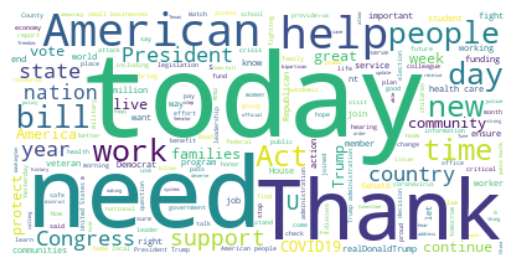

In [7]:
# word cloud of word frequency
text = ' '.join(congress_tweets['tokens'].map(lambda text: ' '.join(text)))
wordcloud = WordCloud(background_color = "white").generate(text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### EDA 2

In [8]:
#scattertext 
congress_tweets['tokens_str'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
corpus = st.CorpusFromPandas(congress_tweets[:5000],
                            category_col = 'party',
                            text_col = 'tokens_str',
                            nlp = nlp).build()


In [9]:
html = st.produce_scattertext_explorer(corpus,
                                       category='Democrat',
                                       category_name='Democrat',
                                       not_category_name='Republican',
                                        width_in_pixels=1000,
                                        minimum_term_frequency=5)

In [10]:
open("TweetSentiments.html", 'wb').write(html.encode('utf-8'))
print('Open TweetSentiments.html in Chrome or Firefox.')

Open TweetSentiments.html in Chrome or Firefox.


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

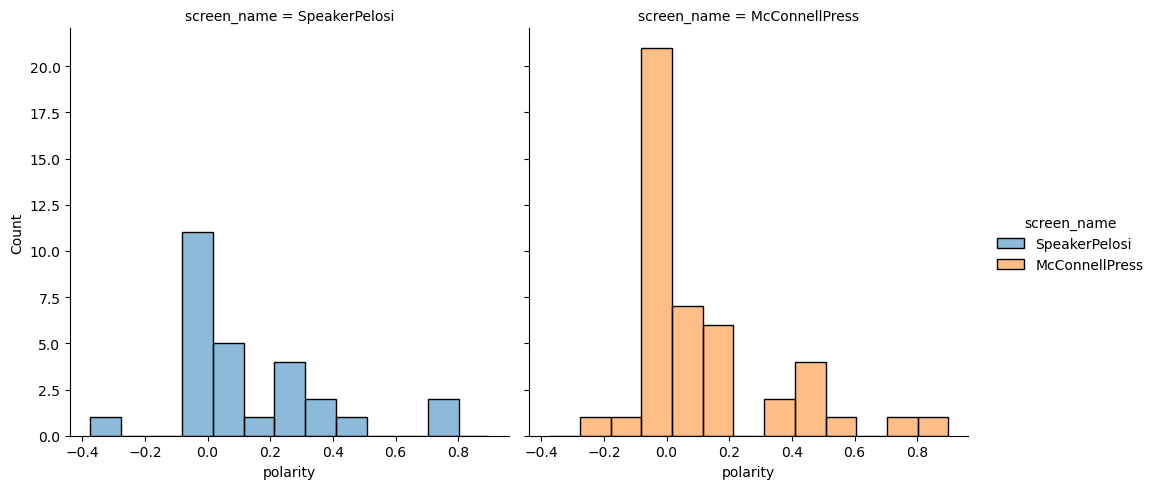

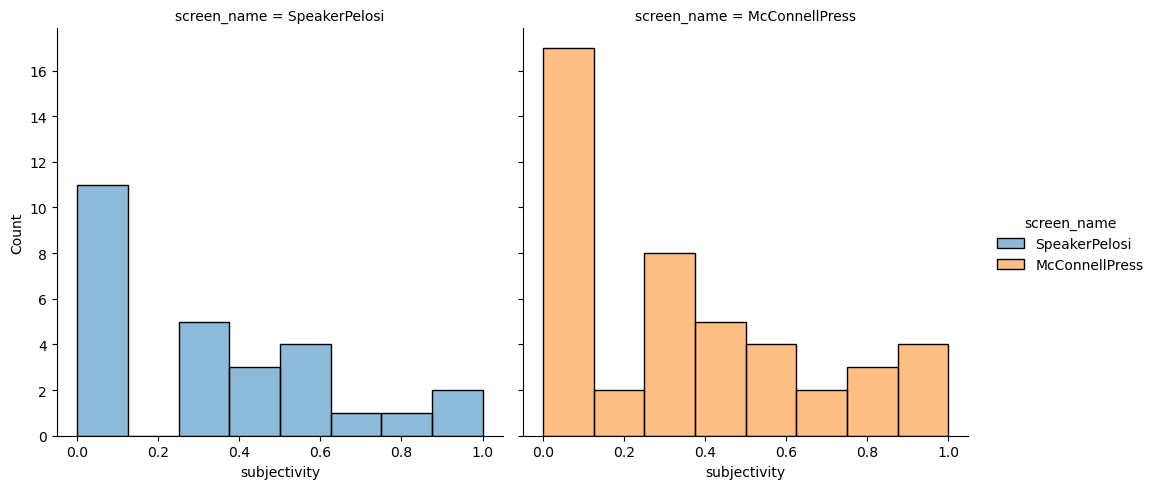

In [11]:
## LEGISLATOR COMPARISON
congress_tweets['polarity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets['subjectivity'] = congress_tweets['tokens_str'].map(lambda text: TextBlob(text).sentiment.subjectivity)
congress_tweets.head()

tweets_subset = congress_tweets[(congress_tweets['screen_name']=='SpeakerPelosi') | (congress_tweets['screen_name'] == 'McConnellPress')]

sns.displot(tweets_subset, x="polarity", hue = "screen_name", col = "screen_name")
plt.show()

sns.displot(tweets_subset, x="subjectivity", hue = "screen_name", col = "screen_name")
plt.show()

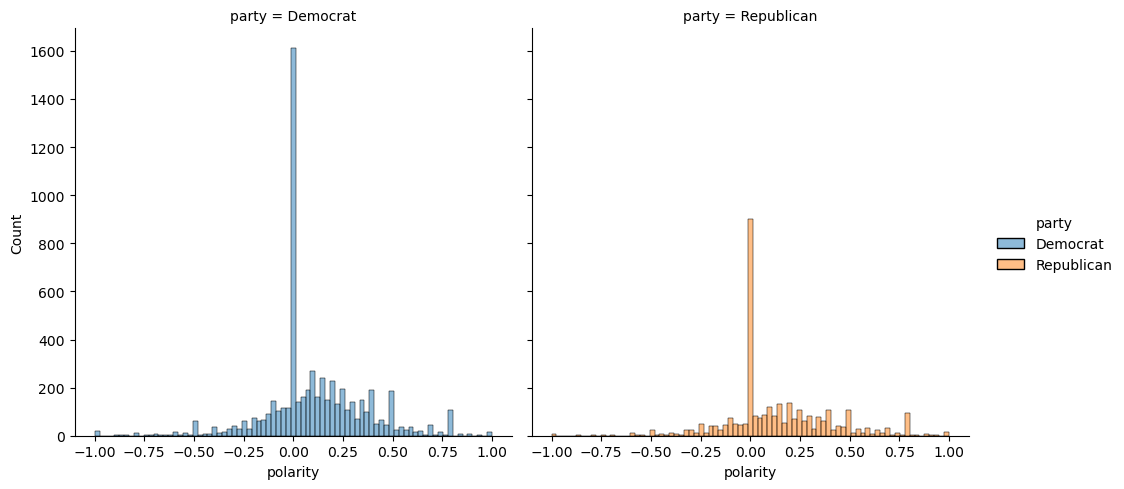

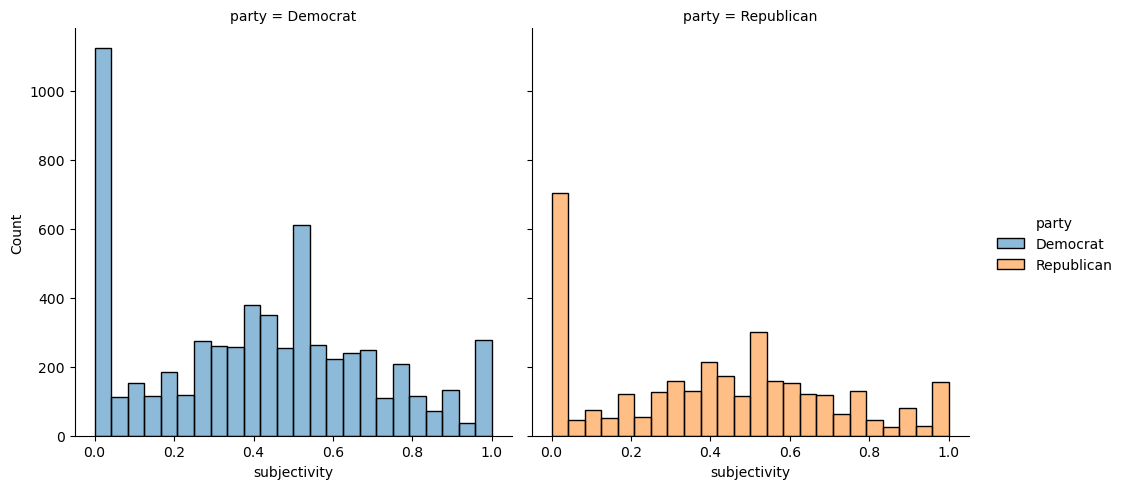

In [12]:
## DEMOCRAT/REPUBLICAN COMPARISON
tweets_subset = congress_tweets[(congress_tweets['party']=='Democrat') | (congress_tweets['party'] == 'Republican')]

sns.displot(congress_tweets, x="polarity", hue = "party", col = "party")
plt.show()

sns.displot(congress_tweets, x="subjectivity", hue = "party", col = "party")
plt.show()

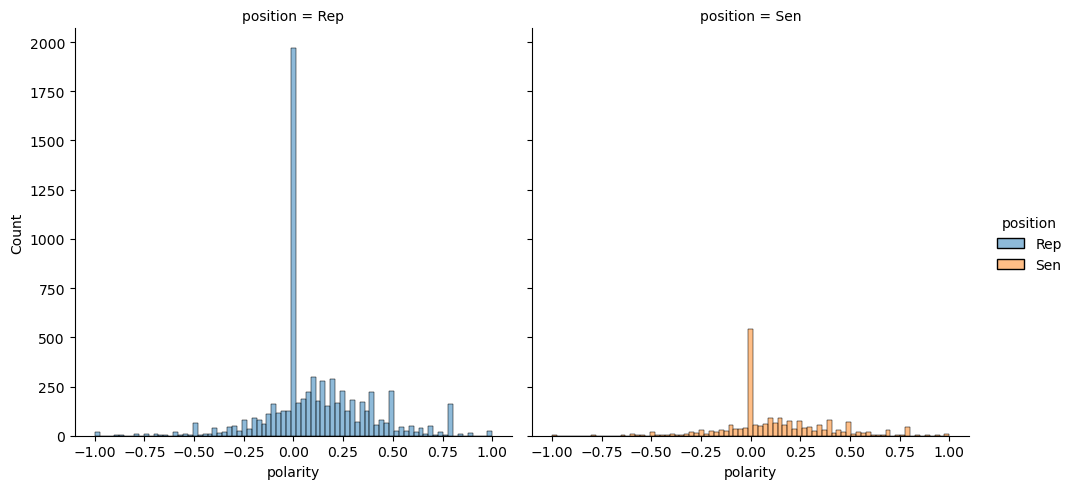

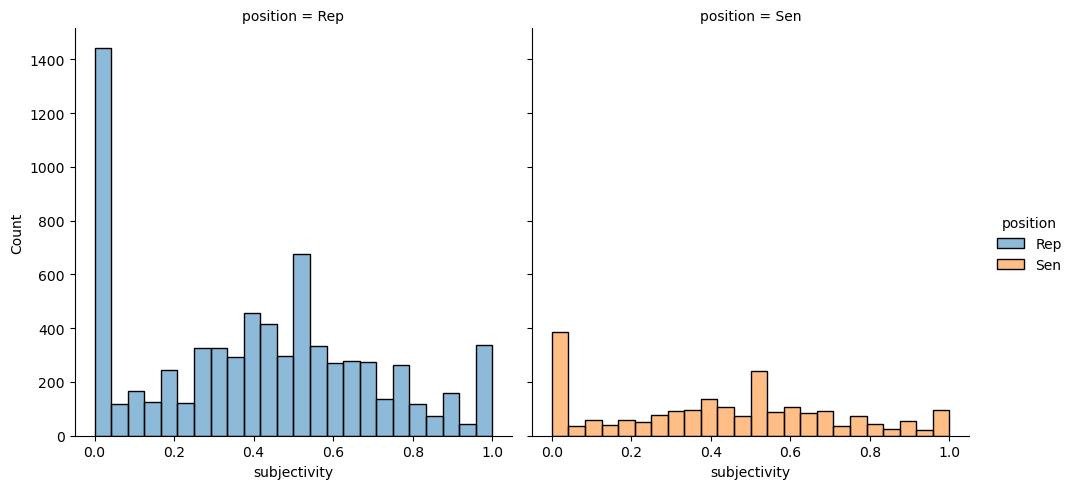

In [13]:
## SENATOR/REPRESENTATIVE COMPARISON
sns.displot(congress_tweets, x="polarity", hue = "position", col = "position")
plt.show()

sns.displot(congress_tweets, x="subjectivity", hue = "position", col = "position")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [14]:
# Engineered Features
congress_tweets['tweet_len'] = congress_tweets['text'].apply(len)
congress_tweets['word_count'] = congress_tweets['text'].apply(lambda x: len(str(x).split()))

engineered_features = congress_tweets[['tweet_len', 'word_count', 'polarity', 'subjectivity']].reset_index(drop = True)
engineered_features

,tweet_len,word_count,polarity,subjectivity
0,320,22,0.000000,0.000000
1,449,42,0.216667,0.450000
2,259,45,0.000000,0.133333
3,394,36,0.025000,0.350000
4,441,42,0.000000,0.300000
...,...,...,...,...
9461,297,32,0.100000,0.100000
9462,292,43,0.366667,0.566667
9463,149,16,0.500000,0.500000
9464,255,37,0.000000,1.000000


### Bag-of-words or Tf-idf

In [15]:
# Frequency Based featurization
tf = TfidfVectorizer(tokenizer = rem_punc_stop)
tfidf_matrix =  tf.fit_transform(congress_tweets['text'])
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out()).reset_index(drop=True)
tfidf_df

,\n\n,\n,\n \n,\n \n,\n,\n \n,\n,\n \n,\n,\n,...,🦰,🦱,🦳,🧊🧊🧊,🧐,🧒,🧪,🧸,🧼,🩺
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9462,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word Embedding

In [16]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

#model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True)

model = gensim.models.Word2Vec(congress_tweets['text'], vector_size=100, window=5, 
                               min_count=5, sg=0, alpha=0.025, epochs = 5, batch_words=10000)

In [17]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.index_to_key]
    #return np.mean(model[doc], axis=0)
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

In [18]:
empty_list_embeddings_means = []
for word in congress_tweets['text']: # append the vector for each document
    empty_list_embeddings_means.append(document_vector(model, word))
    
doc_average_embeddings = np.array(empty_list_embeddings_means) # list to array

In [19]:
doc_average_embeddings.shape

(9466, 100)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [20]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

dataframes = [engineered_features, tfidf_df, doc_average_embeddings]
featurization_technique = ['Engineered Text Features',
                           'Tf-idf Features',
                           'Word2vec Features']

# Y = [Dem/rep, sen/rep]
lb_style = LabelBinarizer()
y_party = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])
y_position = congress_tweets['position_binary'] = lb_style.fit_transform(congress_tweets["position"])

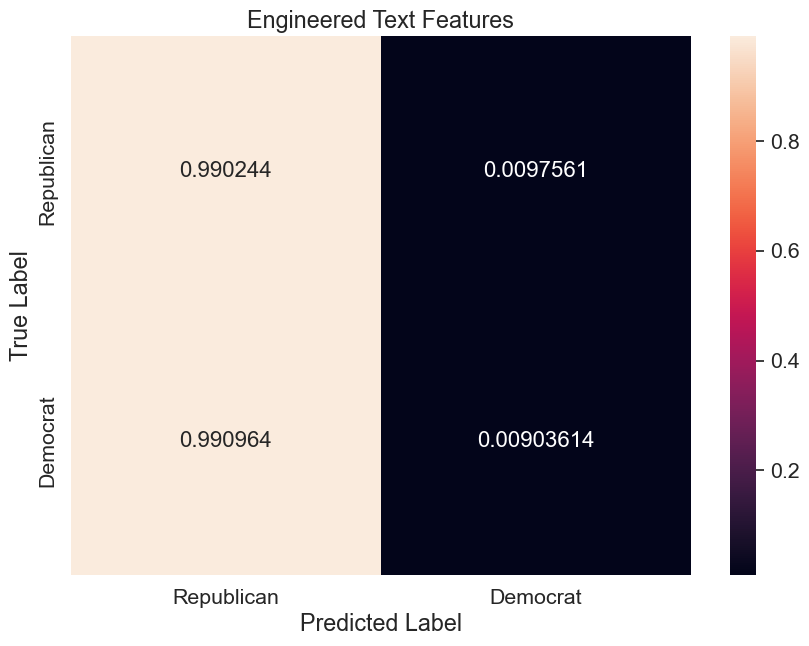

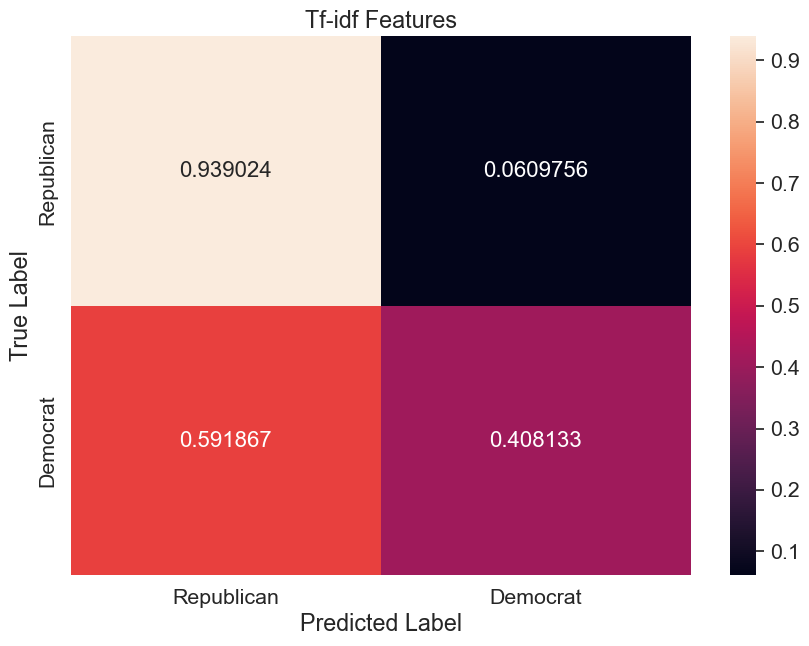

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


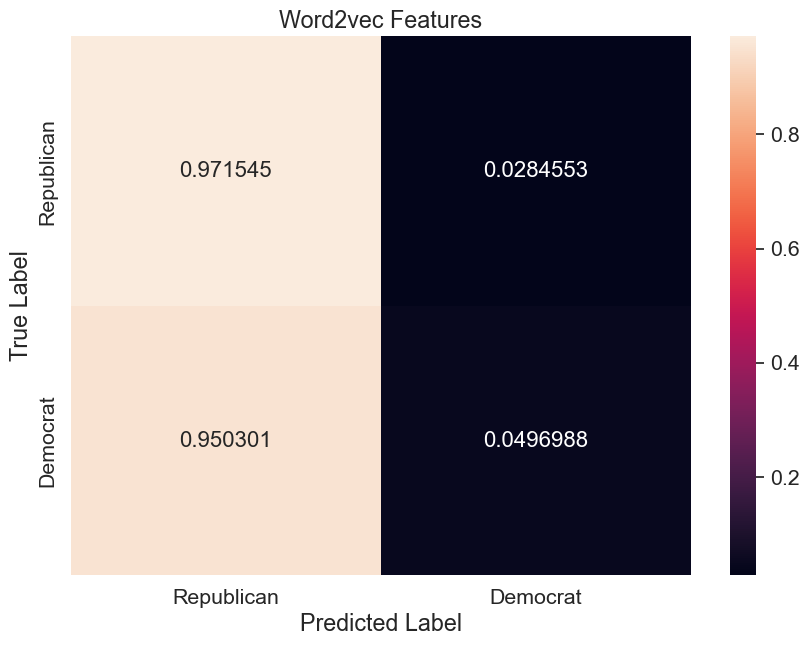

In [21]:
#Dem/Rep
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y_party, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

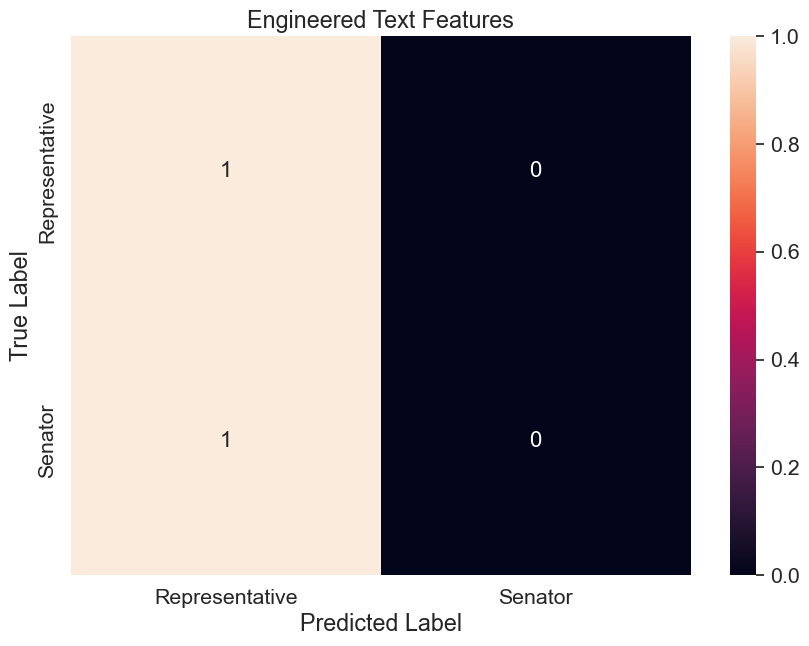

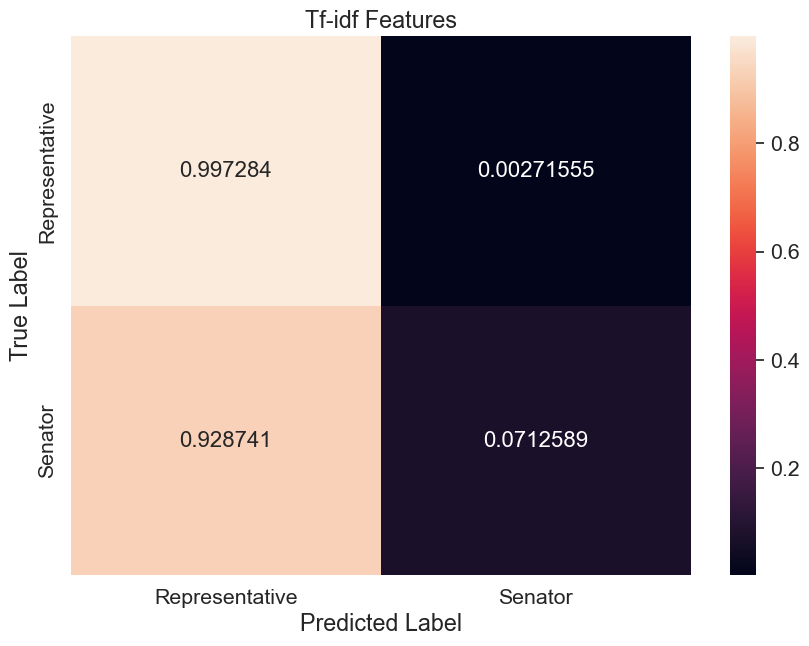

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


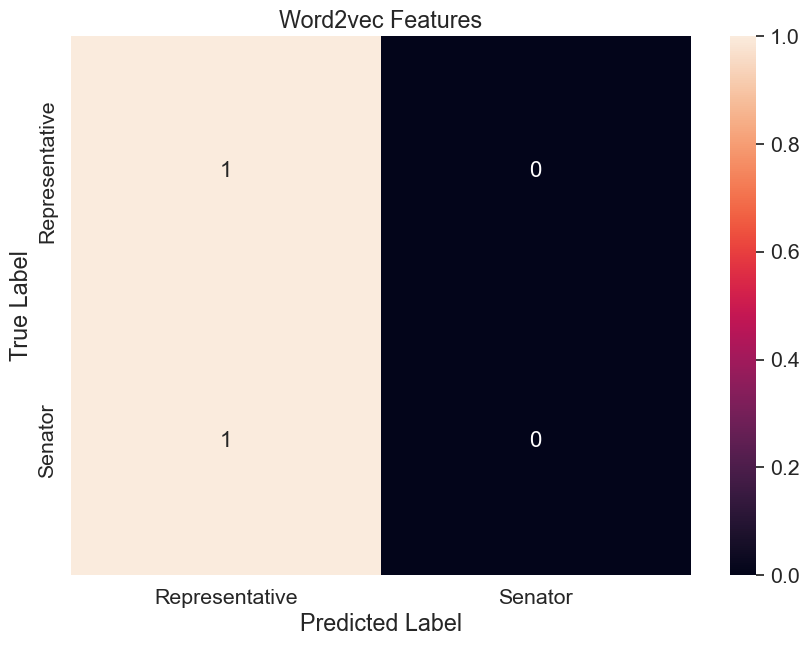

In [22]:
#Dem/Rep
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y_position, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Representative", 1: "Senator"})
    df_cm.index = ["Representative", "Senator"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [25]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
# tf-idf is best performing; add in non-text features
# Non-text features
non_text_features = congress_tweets[['state', 'position', 'trump_2016_state_share', 'clinton_2016_state_share', 'obama_2012_state_share', 'romney_2012_state_share']]
non_text_features_dummies = pd.get_dummies(non_text_features).reset_index(drop = True)

# Non-text features + engineered features
non_text_engineered_features = non_text_features_dummies.reset_index(drop = True).join(tfidf_df)

dataframes = [non_text_features_dummies, non_text_engineered_features]
featurization_technique = ['Non-Text Features', 
                           'Non-Text & Tf-idf Features',]

# Y = [Dem/rep, sen/rep]
lb_style = LabelBinarizer()
y_party = congress_tweets['party_binary'] = lb_style.fit_transform(congress_tweets["party"])



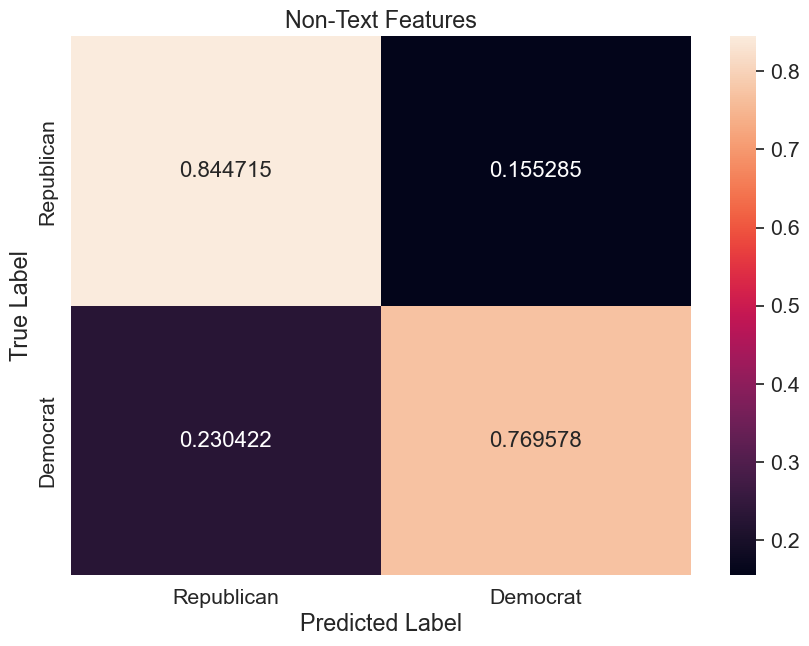

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


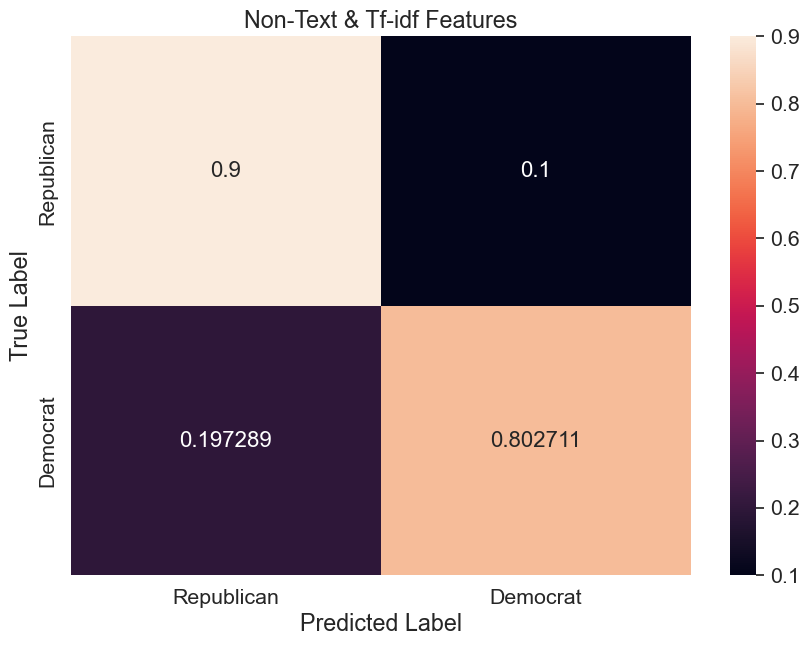

In [26]:
# non-text; non-text + tfidf
#Dem/Rep
for dataframe, featurization in zip(dataframes, featurization_technique):
    X_train, X_test, y_train, y_test = train_test_split(dataframe, 
                                                        y_party, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    # create a model
    logit_reg = LogisticRegression()

    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
    df_cm.index = ["Republican", "Democrat"]
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(featurization)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Every text dataset could have various non-informational data. Tags from html, json, and xml data or tags like "RT", "QT" do not provide useful information from prediction and need to be manually cleaned in order to improve prediction. Without removing them, they may lead to predictions based on correlations that are simply artifacts of the data structure and not of the data content.**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**There were some differences, which I found to be clearest in the scattertext figure. Both the objectivity and sentiment scores did not provide that useful of an analysis, with both groups behaving similarly.**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**A supervised learning algorithm provides a prediction metric rather than solely classification. With exploratory and unsupervised methods, we are only describing patterns. Unsupervised learning algorithms in effect provide a check on the patterns we believe are occurring in the data.**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Text and non-text features performed the best. In this example, tf-idf and other non-text features together provided the best predictions. It is useful to combine text and non-text features when there is additional information that could, in effect, provide context clues about the text itself. Patterns can be detected from the tweet, but previous patterns of voting, for example, provides useful information about past behavior that may relate to present status as Democrat or Republican. On the flipside, previous voting patterns may not capture dynamics over time, and tweets can provide this information of changing beliefs, as demonstrated in what is tweeted.**